<a href="https://colab.research.google.com/github/yajuna/linearRegression/blob/master/linear_regression(version2_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook, we play with measured weather data and measured tree temperature, and try to fit a simple linear regression model. We will Aug 21 data for training the model, and Aug 22 to test the model.
As these two days are close, they will probably have similar weather conditions; next step is to find dates that are far apart from Aug 21, and predict the temperature from different weather condtions.



In [1]:
import numpy as np
import pandas
# import random
# from scipy import sparse
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Numpy version is", np.__version__)
import scipy

print("Scipy version is", scipy.__version__)

Python 3 version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Matplotlib version is 3.7.1
Numpy version is 1.23.5
Scipy version is 1.11.3


In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

Define parameters for linear interpolation of temperature and weather data

In [3]:
# define parameter
n_t = 4000
n_x = 2000
radius = 0.135 # unit m
time = np.linspace(0, 24, n_t, endpoint = False)

## Use data from Aug 21 for training.
From tree temperature data, read core and bark temperature as indepedent variables $X$; read mid_temp1 (at depth 9cm) and mid_temp2 (at depth 4.5cm) as dependent variables $Y$.
From weather data, read wind_speed, wind_direction, humidity, temperature, air_pressure, solar_DNI. wind direction is unlikely to have a linear relation to the temperature, so we delete it from independent variables.

In [4]:
train_tree_temp_index = 416 - 2
train_weather_index = 145 - 2

test_tree_temp_index = 827 - 2
test_weather_index = 289 -2

train_interp_temp_size = train_tree_temp_index
train_interp_weather_size = train_weather_index

test_interp_temp_size = test_tree_temp_index - train_tree_temp_index
test_interp_weather_size = test_weather_index - train_weather_index

In [5]:
colnames = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
dataTemp = pandas.read_excel(url1,names=colnames)

# if use data locally:
# dataTemp = pandas.read_excel('Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx', names=colnames)

# training data processing- measured temp of tree at various depths

# core temp is west, at 13.5cm, at 2m high
train_coreTemp = np.array(dataTemp.s135_3[:train_tree_temp_index])+ 273.15
# West, at 9cm, at 3m high
train_midTemp1 = np.array(dataTemp.w9_3[:train_tree_temp_index])+ 273.15
# North, at 4.5cm, at 3m high
train_midTemp2 = np.array(dataTemp.n45_3[:train_tree_temp_index])+ 273.15
# bark temp is West, at bark, at 3.5m high
train_barkTemp = np.array(dataTemp.w_ext_35[:train_tree_temp_index])+ 273.15

# linear interpolate the measured temperature
train_coreTemp = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_coreTemp)
train_midTemp1 = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_midTemp1)
train_midTemp2 = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_midTemp2)
train_barkTemp = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_barkTemp)

# testing data processing- measured temp of tree at various depths

# core temp is west, at 13.5cm, at 2m high
test_coreTemp = np.array(dataTemp.s135_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# West, at 9cm, at 3m high
test_midTemp1 = np.array(dataTemp.w9_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# North, at 4.5cm, at 3m high
test_midTemp2 = np.array(dataTemp.n45_3[train_tree_temp_index: test_tree_temp_index])+ 273.15
# bark temp is West, at bark, at 3.5m high
test_barkTemp = np.array(dataTemp.w_ext_35[train_tree_temp_index: test_tree_temp_index])+ 273.15

# linear interpolate the measured temperature
test_coreTemp = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_coreTemp)
test_midTemp1 = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_midTemp1)
test_midTemp2 = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_midTemp2)
test_barkTemp = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_barkTemp)

print("measured temperature data read")

# initial tree temperature linearly interpolated
# initTemp = np.array([test_coreTemp[0], test_midTemp1[0], test_midTemp2[0], test_barkTemp[0]])
# init_temp = np.interp(np.linspace(0,radius,n_x), np.linspace(0,radius,initTemp.size), initTemp)

measured temperature data read


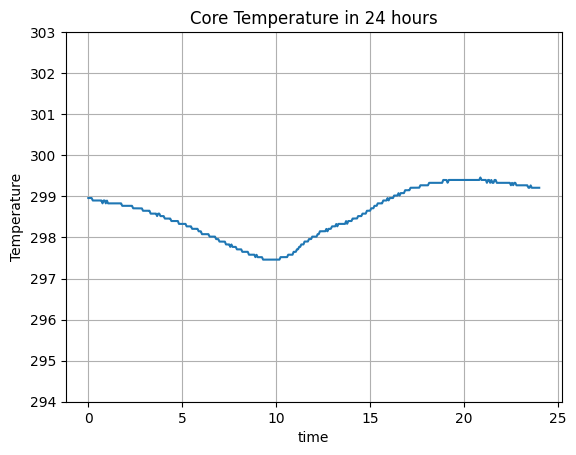

In [6]:
# plot train temp
fig1, ax = plt.subplots()
ax.plot(time, train_coreTemp)

ax.set(xlabel='time', ylabel='Temperature',
       title='Core Temperature in 24 hours')
ax.set_ylim(294, 303)
ax.grid()

fig1.savefig("coreTemp.eps")
plt.show()

In [9]:
### Read weather data

colnames = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
dataWeather = pandas.read_excel(url2,names=colnames)

# if use locally:
# dataWeather = pandas.read_excel('Weather_Station_OCT21_to_OCT28_2022.xlsx', names = colnames)


#### training
# wind speed from Oct 21
train_windSpeed = np.array(dataWeather.wind_speed[:train_weather_index])
# humidity from Oct 21
train_humidity = np.array(dataWeather.humidity[:train_weather_index])
# air temperature from Oct 21
train_airTemp = np.array(dataWeather.air_temperature[:train_weather_index])+ 273.15
# air pressure from Oct 21
train_airPressure = np.array(dataWeather.air_pressure[:train_weather_index])
# solar radiation from Oct 21
train_solar = np.array(dataWeather.solar_DNI[:train_weather_index])

### linear interpret
train_airTemp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_airTemp)
train_windSpeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_windSpeed)
train_solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_solar)

train_humidity = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_humidity)
train_airPressure = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_airPressure)
#### testing
# wind speed from Oct 21
test_windSpeed = np.array(dataWeather.wind_speed[train_weather_index: test_weather_index])
# humidity from Oct 21
test_humidity = np.array(dataWeather.humidity[train_weather_index: test_weather_index])
# air temperature from Oct 21
test_airTemp = np.array(dataWeather.air_temperature[train_weather_index: test_weather_index])+ 273.15
# air pressure from Oct 21
test_airPressure = np.array(dataWeather.air_pressure[train_weather_index: test_weather_index])
# solar radiation from Oct 21
test_solar = np.array(dataWeather.solar_DNI[train_weather_index: test_weather_index])

test_airTemp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_airTemp)
test_windSpeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_windSpeed)
test_solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_solar)

test_humidity = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_humidity)
test_airPressure = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_airPressure)

print("weather data read")

weather data read


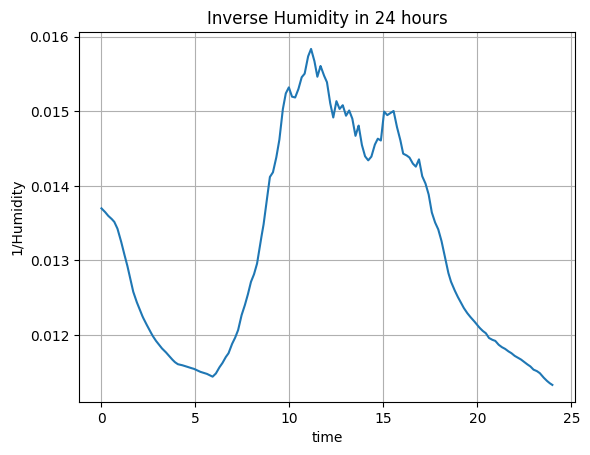

In [10]:
# plot train weather
fig2, ax = plt.subplots()
ax.plot(time, 1./train_humidity)

ax.set(xlabel='time', ylabel='1/Humidity',
       title='Inverse Humidity in 24 hours')
#ax.set_ylim(294, 303)
ax.grid()

fig2.savefig("train_humidity_inv.eps")
plt.show()

# Prepare training and testing data


In [52]:
#include depth as training variable
# n = 0 for 9cm; n = 1 for 4.5cm
n = 1
depth_list = [9/radius, 4.5/radius]

# training Y temp
Ytrain_list = [train_midTemp1, train_midTemp2]

Ytest_list = [test_midTemp1, test_midTemp2]

# depth for training is depth1 or depth2
depth = np.ones(train_coreTemp.shape) * depth_list[n]

# include initial temperature
ic_train = np.ones(train_coreTemp.shape) * Ytrain_list[n][0]

# Training data in x; training data in y
Xtrain = [train_airTemp, train_windSpeed, train_solar, ic_train, depth, train_coreTemp, train_barkTemp]
X_train = np.array(Xtrain).T
Y_train = Ytrain_list[n]

# testing data in x, testing data in y.
ic_test = np.ones(test_coreTemp.shape) * Ytest_list[n][0]
Xtest = [test_airTemp, test_windSpeed, test_solar, ic_test, depth, test_coreTemp, test_barkTemp]
X_test = np.array(Xtest).T
Y_test = Ytest_list[n]

In [53]:
model = LinearRegression()

In [54]:
model.fit(X_train,Y_train)

LinearRegression()

In [55]:
predictions = model.predict(X_test)

In [56]:
print(max(Y_test), min(Y_test), max(predictions), min(predictions))

300.46 296.83 300.27852254525317 296.1952680562688


In [59]:
print(
  'mean_squared_error : ', mean_squared_error(Y_test, predictions))
print(
  'mean_absolute_error : ', mean_absolute_error(Y_test, predictions))

print('max error:', max(abs(Y_test - predictions)))

mean_squared_error :  0.24660775073117383
mean_absolute_error :  0.413393575520407
max error: 1.4130717060924667


In [60]:
print(max(abs(Y_test - predictions)))

1.4130717060924667


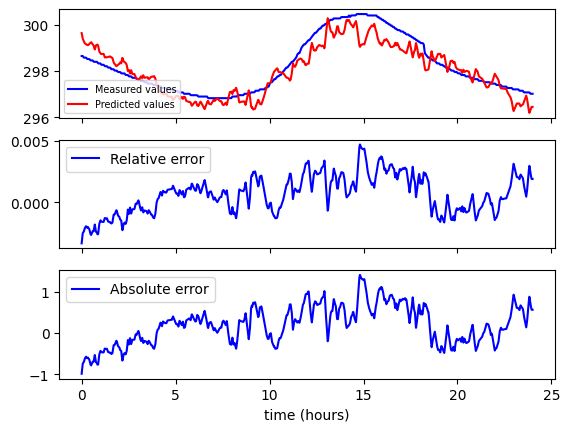

In [51]:
# visualization

fig, axs = plt.subplots(3, sharex=True, sharey=False)
# fig.suptitle('Measured temperature, predicted temperature, absolute, and relative error')
axs[0].plot(time, Y_test, 'b-', label='Measured values')
axs[0].plot(time, predictions, 'r-', label='Predicted values')
axs[1].plot(time, (Y_test - predictions)/Y_test, 'b-', label='Relative error')
axs[2].plot(time, Y_test - predictions, 'b-', label='Absolute error')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend()
axs[2].legend()
plt.xlabel('time (hours)', fontsize=10)
fig.savefig("test2.eps")
plt.show()